In [2]:
import pandas as pd 
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
from pathlib import Path
currdir = os.getcwd()
parent = os.path.dirname(currdir)
gparent = os.path.dirname(parent)

In [3]:
def ensure_dirs_exists(path):
    if "." in path:
	    path = os.path.dirname(path)
    if not os.path.exists(path):
        os.makedirs(path)
    return

In [4]:
def get_module_dictionary(filename):
    if 'xlsx' in filename:
        all_modules_data = pd.read_excel(filename, sheet_name = 'Partition',engine='openpyxl')
    elif 'csv' in filename:
        all_modules_data = pd.read_csv(filename)
    module_nums = all_modules_data['Membership'].unique()
    prefixed_module_nums = ["M" + str(num) for num in module_nums]
    module_dict = {key: [] for key in prefixed_module_nums}
    for key in module_dict.keys():
        corresp_genes = all_modules_data.loc[all_modules_data['Membership'] == int(key[1:]), 'Symbol'].tolist()
        module_dict[key].extend(corresp_genes)
    return module_dict

MODULE_FILE = f"{gparent}/example_data/tables/LRRK2-TMT-Module-Results.xlsx" # going into example_data/. user should fix to equal level hierarchy folder
gene_modules_dict = get_module_dictionary(MODULE_FILE)


In [5]:
def wait_for_file_and_rename(directory, desired_name):
    prev_files = set(os.listdir(directory))
    while True:
        time.sleep(1)  # polling interval
        current_files = set(os.listdir(directory))
        new_files = current_files - prev_files
        print(f'New files: {new_files}')  # Debugging line
        if new_files:
            file_to_rename = new_files.pop()  # get the new file
            current_file_path = os.path.join(directory, file_to_rename)
            new_file_path = os.path.join(directory, desired_name)
            ensure_dirs_exists(new_file_path)
            os.rename(current_file_path, new_file_path)
            print(f"renamed to {new_file_path}")
            break
        prev_files = current_files

In [6]:
def get_background_genes(file):
    background_df = pd.read_csv(file)
    background_genes = list(background_df['Gene'])
    return background_genes

background_genes_file = f"{gparent}/example_data/BackgroundDatabase.csv"
bkrgd_genes = get_background_genes(background_genes_file)
print(f"This is the length of background genes: {len(bkrgd_genes)}, {type(bkrgd_genes)}")


This is the length of background genes: 9767, <class 'list'>


In [7]:

class table_updated_condition(object):
    def __call__(self, browser):
        table = browser.find_element(By.CLASS_NAME, "shiny-table")
        # Replace the following line with your condition
        rows = table.find_elements(By.TAG_NAME, "tr")
        return len(rows) > 0

In [8]:
import time 
from selenium.webdriver.chrome.options import Options

def get_shinygo_analysis(genes, background_genes, GENE_NAME, key):
    download_dir = f"{parent}/ShinyGO_data/{GENE_NAME}_biological_comp/"

    chrome_options = Options()
    chrome_options.add_experimental_option("prefs", {
        "download.default_directory": download_dir,
        "download.prompt_for_download": False,
        "download.directory_upgrade": True,
        "safebrowsing.enabled": True
    })

    browser = webdriver.Chrome(options=chrome_options)
    browser.get("http://bioinformatics.sdstate.edu/go/")
    print(browser.title)
    wait = WebDriverWait(browser, 5) # 10 seconds timeout

    ## Select mouse 
    species_dropdown_control = wait.until(EC.visibility_of_element_located((By.CLASS_NAME, "selectize-input")))
    species_dropdown_control.click()
    # Pause to allow dropdown RENDER
    time.sleep(5)
    # use JavaScript to select the "Mouse" option
    js_script = """
    var selectize_elements = document.querySelectorAll('.selectize-dropdown-content div[data-value]');
    for(var i = 0; i < selectize_elements.length; i++){
        if(selectize_elements[i].getAttribute('data-value') === '131'){
            selectize_elements[i].click();
            break;
        }
    }
    """
    browser.execute_script(js_script)

    # Module genes
    main_box = browser.find_element(By.XPATH, '//textarea[contains(@placeholder, "Just paste a list of genes")]')
    genes_string = '\n'.join(genes)
    main_box.send_keys(genes_string)
    wait = WebDriverWait(browser, 10) # 10 seconds timeout
    element_xpath = '/html/body/div[18]'
    element = wait.until(EC.element_to_be_clickable((By.XPATH, element_xpath)))

    # Background genes population
    button = browser.find_element(By.ID, "backgroundGenes")
    button.click()
    textarea = wait.until(EC.visibility_of_element_located((By.ID, "input_text_b")))
    # Input your text into the textarea
    script = "arguments[0].value = arguments[1];"
    browser.execute_script(script, textarea, ' '.join(background_genes)) #####################################################################
    browser.find_element(By.TAG_NAME, 'body').click()

    wait = WebDriverWait(browser, 20)
    submit_button = browser.find_element(By.ID, 'goButton')
    submit_button.click()

    # Wait for the table to appear first
    table = WebDriverWait(browser, 80).until(
        EC.visibility_of_element_located((By.CLASS_NAME, "shiny-table"))
    )
    print("submitted initial table")

    # Ensure the "KEGG" option is present before proceeding
    # kegg_option_xpath = '//div[@data-value="KEGG"]'
    # wait.until(EC.visibility_of_element_located((By.XPATH, kegg_option_xpath)))
    # Interact with the dropdown now
    dropdown_xpath = '//*[@id="selectGO-selectized"]'
    wait.until(EC.visibility_of_element_located((By.XPATH, dropdown_xpath)))

    selectize_input = browser.find_element(By.ID, "selectGO-selectized")
    selectize_input.click()

    # Wait for the "GO 0 Component" option and click on it
    go_cellular_component_option_xpath = '//div[@role="listbox"]/div[@data-value="GOBP"]' ## CELLcomp
    go_cellular_component_option = wait.until(EC.element_to_be_clickable((By.XPATH, go_cellular_component_option_xpath)))
    go_cellular_component_option.click()
    print("Corrected pathway to access... KEGG -> BioComp/CellComp")
    
    # wait for shinytable to update....?
    wait = WebDriverWait(browser, 80)
    wait.until(table_updated_condition())

    # Now grab the updated table
    table = browser.find_element(By.CLASS_NAME, "shiny-table")
    
    # Click the download button
    download_button = wait.until(EC.element_to_be_clickable((By.ID, 'downloadEnrichmentAll')))
    download_button.click()
    print("downloading all pathways........")
    ensure_dirs_exists(download_dir)
    # Wait for the download to complete and rename it
    desired_filename = f"{GENE_NAME}_{key}.csv"
    wait_for_file_and_rename(download_dir, desired_filename)

    browser.quit()
    print(f"Finished module {key}")
    return
    
GENE_NAME = "LRRK2"
# M4 = gene_modules_dict['M4']
# get_shinygo_analysis(gene_modules_dict['M4'], bkrgd_genes, GENE_NAME, 'M4')
for key, values in gene_modules_dict.items():
    get_shinygo_analysis(values, bkrgd_genes, GENE_NAME, key)

ShinyGO 0.80
submitted initial table
Corrected pathway to access... KEGG -> BioComp/CellComp
downloading all pathways........
New files: set()
New files: {'enrichment_all.csv'}
renamed to /home/poojaparameswaran/Documents/SoderlingLab/SpatialProteomics/ShinyGo/ShinyGO_data/LRRK2_biological_comp/LRRK2_M0.csv
Finished module M0
ShinyGO 0.80
submitted initial table
Corrected pathway to access... KEGG -> BioComp/CellComp
downloading all pathways........
New files: set()
New files: set()
New files: set()
New files: set()
New files: set()
New files: set()
New files: set()
New files: set()
New files: set()
New files: set()
New files: set()
New files: set()
New files: set()
New files: set()
New files: set()
New files: set()
New files: set()
New files: set()
New files: set()
New files: set()
New files: set()
New files: set()
New files: {'enrichment_all.csv'}
renamed to /home/poojaparameswaran/Documents/SoderlingLab/SpatialProteomics/ShinyGo/ShinyGO_data/LRRK2_biological_comp/LRRK2_M1.csv
Finish

NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=120.0.6099.199)
Stacktrace:
#0 0x55fa51d21f83 <unknown>
#1 0x55fa519dacf7 <unknown>
#2 0x55fa519ae728 <unknown>
#3 0x55fa51a5b69f <unknown>
#4 0x55fa51a72719 <unknown>
#5 0x55fa51a53e53 <unknown>
#6 0x55fa51a1bdd4 <unknown>
#7 0x55fa51a1d1de <unknown>
#8 0x55fa51ce6531 <unknown>
#9 0x55fa51cea455 <unknown>
#10 0x55fa51cd2f55 <unknown>
#11 0x55fa51ceb0ef <unknown>
#12 0x55fa51cb699f <unknown>
#13 0x55fa51d0f008 <unknown>
#14 0x55fa51d0f1d7 <unknown>
#15 0x55fa51d21124 <unknown>
#16 0x7f671735e609 start_thread


In [10]:
def load_data(foldername, gene_name):
    
    datafolder_path = os.path.join(parent, foldername)
    print(f"Your data path is {datafolder_path}")
    module_files = os.listdir(datafolder_path)
    modules_found = []
    for i in module_files:
        if gene_name in i:  # Check if the gene name is in the filename
            match = re.search(f'{gene_name}_M(\d+).csv', i)
            if match:
                modules_found.append(match.group())
    modules_found = sorted(modules_found, key=lambda x: int(re.search(f'{gene_name}_M(\d+).csv', x).group(1)))
    module_files = [f for f in module_files if gene_name in f]  # Filter files for the specific gene
    module_files = sorted(module_files, key=lambda x: int(re.search(f'{gene_name}_M(\d+).csv', x).group(1)))
    ###### starting to create DataFrames ##########
    print("We are looking at GO Cellular Components")
    module_dfs = {}
    if len(modules_found) == len(module_files):
        for ind, file in enumerate(module_files):
            module_dfs[modules_found[ind].split(".")[0]] = pd.read_csv(os.path.join(datafolder_path, file))
            # print(os.path.join(datafolder_path, file))
    else:
        return "Module files and modules found lengths do not match!! Possible mismatch!!!!!"
    return module_dfs

module_dataframes = load_data(f"ShinyGO_data/{GENE_NAME}_biological_comp/", GENE_NAME)
print(f"If successful this should be a dictionary! {type(module_dataframes)}") ## if successful, dictionary of dataframes should be loaded! If string check issue.


Your data path is /home/poojaparameswaran/Documents/SoderlingLab/SpatialProteomics/ShinyGo/ShinyGO_data/LRRK2_biological_comp/
We are looking at GO Cellular Components
If successful this should be a dictionary! <class 'dict'>


In [11]:
module_dataframes['LRRK2_M4']

,Enrichment FDR,nGenes,Pathway Genes,Fold Enrichment,Pathway,URL,Genes
0,1.025232e-10,30,1516,4.975717,GO:0006629 lipid metabolic process,http://amigo.geneontology.org/amigo/term/GO:0...,DPM1 CYP46A1 HACD3 TECR ABHD12 CDIPT FA...
1,1.025232e-10,26,1103,5.926952,GO:0044255 cellular lipid metabolic process,http://amigo.geneontology.org/amigo/term/GO:0...,DPM1 HACD3 TECR ABHD12 CDIPT FAAH ALG2 ...
2,2.123375e-10,22,776,7.128441,GO:0008610 lipid biosynthetic process,http://amigo.geneontology.org/amigo/term/GO:0...,DPM1 HACD3 TECR CDIPT PIGT SLC27A2 SCCP...
3,4.157868e-09,29,1695,4.301916,GO:0016192 vesicle-mediated transport,http://amigo.geneontology.org/amigo/term/GO:0...,RALA ATP9A VPS35 RAB10 SCFD1 KDELR3 RAB...
4,7.426097e-08,28,1795,3.922177,GO:0045184 establishment of protein localization,http://amigo.geneontology.org/amigo/term/GO:0...,SEC61A1 VPS35 RAB10 SCFD1 RAB18 RAB5C R...
...,...,...,...,...,...,...,...
952,1.990719e-01,1,21,11.973312,GO:0071451 cellular response to superoxide,http://amigo.geneontology.org/amigo/term/GO:0...,SOD2
953,1.990719e-01,1,21,11.973312,GO:0097049 motor neuron apoptotic process,http://amigo.geneontology.org/amigo/term/GO:0...,RHOA
954,1.990719e-01,1,21,11.973312,GO:0097734 extracellular exosome biogenesis,http://amigo.geneontology.org/amigo/term/GO:0...,ATP9A
955,1.990719e-01,1,21,11.973312,GO:0106030 neuron projection fasciculation,http://amigo.geneontology.org/amigo/term/GO:0...,CRTAC1


In [12]:
def parse_data(module_dfs):
    populated_module_dfs = {}
    for key, value in module_dfs.items():
        try:
            updated_df = value.drop(columns=["URL"]) if "URL" in value.columns else value # This is where the KeyError might happen
            updated_df = updated_df[updated_df["Enrichment FDR"] <= 0.05]
            populated_module_dfs[key] = updated_df
        except KeyError as e:
            print(f"KeyError encountered for module: {key}. Missing column: {e}")
            continue
    return populated_module_dfs

populated_module_dfs = parse_data(module_dataframes)


In [13]:
def prep_data_heatmap(module_dfs, GENE_NAME):
    heatmap = {}
    pathways = []
    for key in module_dfs.keys():
        heatmap[key] = None
        for cellcomp in module_dfs[key]["Pathway"]:
            if cellcomp not in pathways:
                pathways.append(cellcomp)
    print(len(pathways))
    heatmap_df = pd.DataFrame(heatmap, index=pathways)
    for module, df in module_dfs.items():
        for index, row in df.iterrows():
            heatmap_df.at[row["Pathway"], module] = row["Enrichment FDR"]
                # heatmap_df = heatmap_df.at[heatmap]
    heatmap_df.fillna(-0.000000001, inplace=True)
    
    # get only top 2 pathways for each module
    indices = []
    for col in heatmap_df.columns:
        indices.extend(heatmap_df.nlargest(2, col).index)
    
    PATHWAY = "BiologicalComponent" ## CHANGE
    # get unique indices
    unique_indices = list(set(indices))
    
    # keep only rows with indices in unique_indices
    heatmap_df = heatmap_df.loc[unique_indices]
    SAVE_HEATMAP = f"{parent}/ShinyGO_data/raw_heatmaps/{GENE_NAME}/{GENE_NAME}_heatmap_top_pathways_{PATHWAY}.csv"
    ensure_dirs_exists(SAVE_HEATMAP)
    heatmap_df.to_csv(SAVE_HEATMAP)
    return heatmap_df
heatmapdata = prep_data_heatmap(populated_module_dfs, GENE_NAME)

print( heatmapdata.shape)

840
(10, 5)


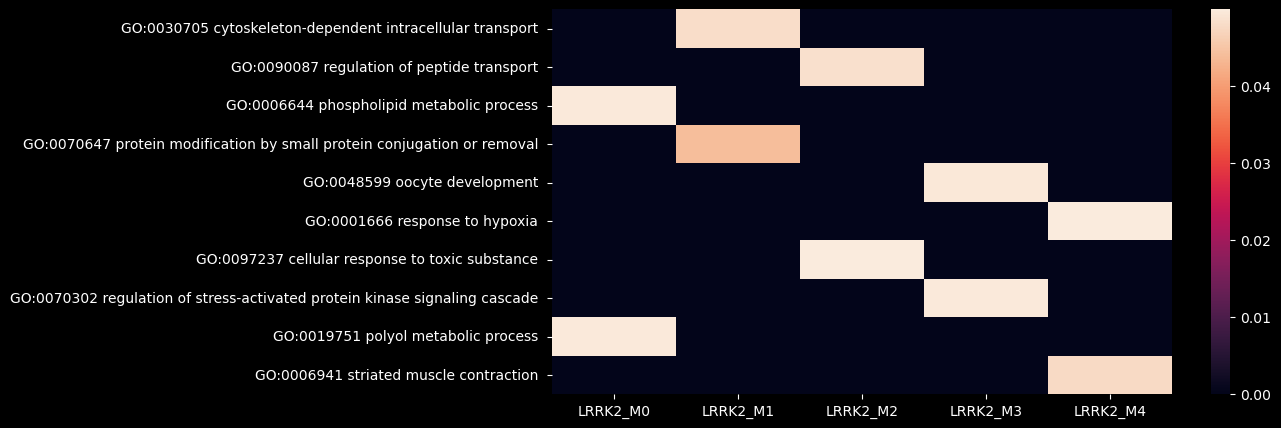

In [14]:
def create_heatmap(heatmap_data):
    plt.figure(figsize=(10, len(heatmapdata.index) * 0.5))  # Adjust the figure size
    sns.heatmap(heatmap_data)
    plt.yticks(rotation=0)  # Rotate y-axis labels
    plt.show()
create_heatmap(heatmapdata)